## I. 问题的定义

### 项目概述

　　汽车的发明给人类社会带来了巨大的发展，人们的出行变得方便快捷，但随之也带来了交通拥堵与交通事故等问题。而随着计算机技术的发展，越来越多的自动控制技术被应用在汽车上，无人驾驶汽车也成为了汽车产业的一大变革。早在20世纪80年代，美国就提出自主地面车辆 (ALV)计划，这是一辆8轮车，能在校园的环境中自主驾驶，但车速不高。世界各大强国也在这方面投入资源。
 
　　近年来，随着深度学习的发展，无人驾驶发展非常迅速。其中比较具代表性的分别是Mobileye的自动驾驶布局，英伟达的DRIVE解决方案以及Commaai的方法，后两者都有采用的端到端方法，指以摄像头的原始图像作为输入，中间通过前期使用数据训练出来的模型直接输出车辆的速度和方向。[1]
  
　　本项目基于"MIT 6.S094: Deep Learning for Self-Driving Cars"。在该项目中，我们利用MIT 6.S094 这门公开课中的Tesla行驶数据集中前置相机所拍摄的路况图像，训练深度学习模型，利用该模型对车辆转向角度的预测。[2]


### 问题陈述

　　该项目是一个监督回归问题。训练数据集中对应每一帧图像都给定了相应的方向盘转向角度。此处使用端到端(end-to-end)模型，端到端模型指的是输入是原始数据，输出是最后的结果。在本问题中，输入X是前置摄像头获取的单帧图片，而最后的结果Y为转向角度，我们的目标就是通过训练学习到一个端到端模型f，利用该模型则可以预测转向角度Y，其关系为Y=f(X)。

### 评价指标

　　该项目是回归问题，该问题的评价指标主要有两个，预测结果平均损失函数(MSE)以及模型的训练和预测时长。MSE表达式如下，其中 $y_{p}$ 表示预测转向角度，y为实际转向角度，N为样本总数。MSE值越小，则模型效果越好。

$MSE=\dfrac {1} {N}\sum _{i=1}^{N}{(y_{p}-y)}^2$

## II. 分析

### 数据的探索

　　先来看一下项目的输入，项目的原始数据来处于汽车的前置摄像头，以mkv的视频格式提供的，共10段视频，其中第10段视频将用于测试，第1到第9个视频经提取后，共有24300张图片，图片形状为（720，1200，3）。


　　从第1个视频中随机获取9张图如下，我们可以看到，照片中会有大量无用区域(如天空，车辆，相机反光等)，在预处理时需要把这些部分去掉，可以压缩训练数据加快模型训练。

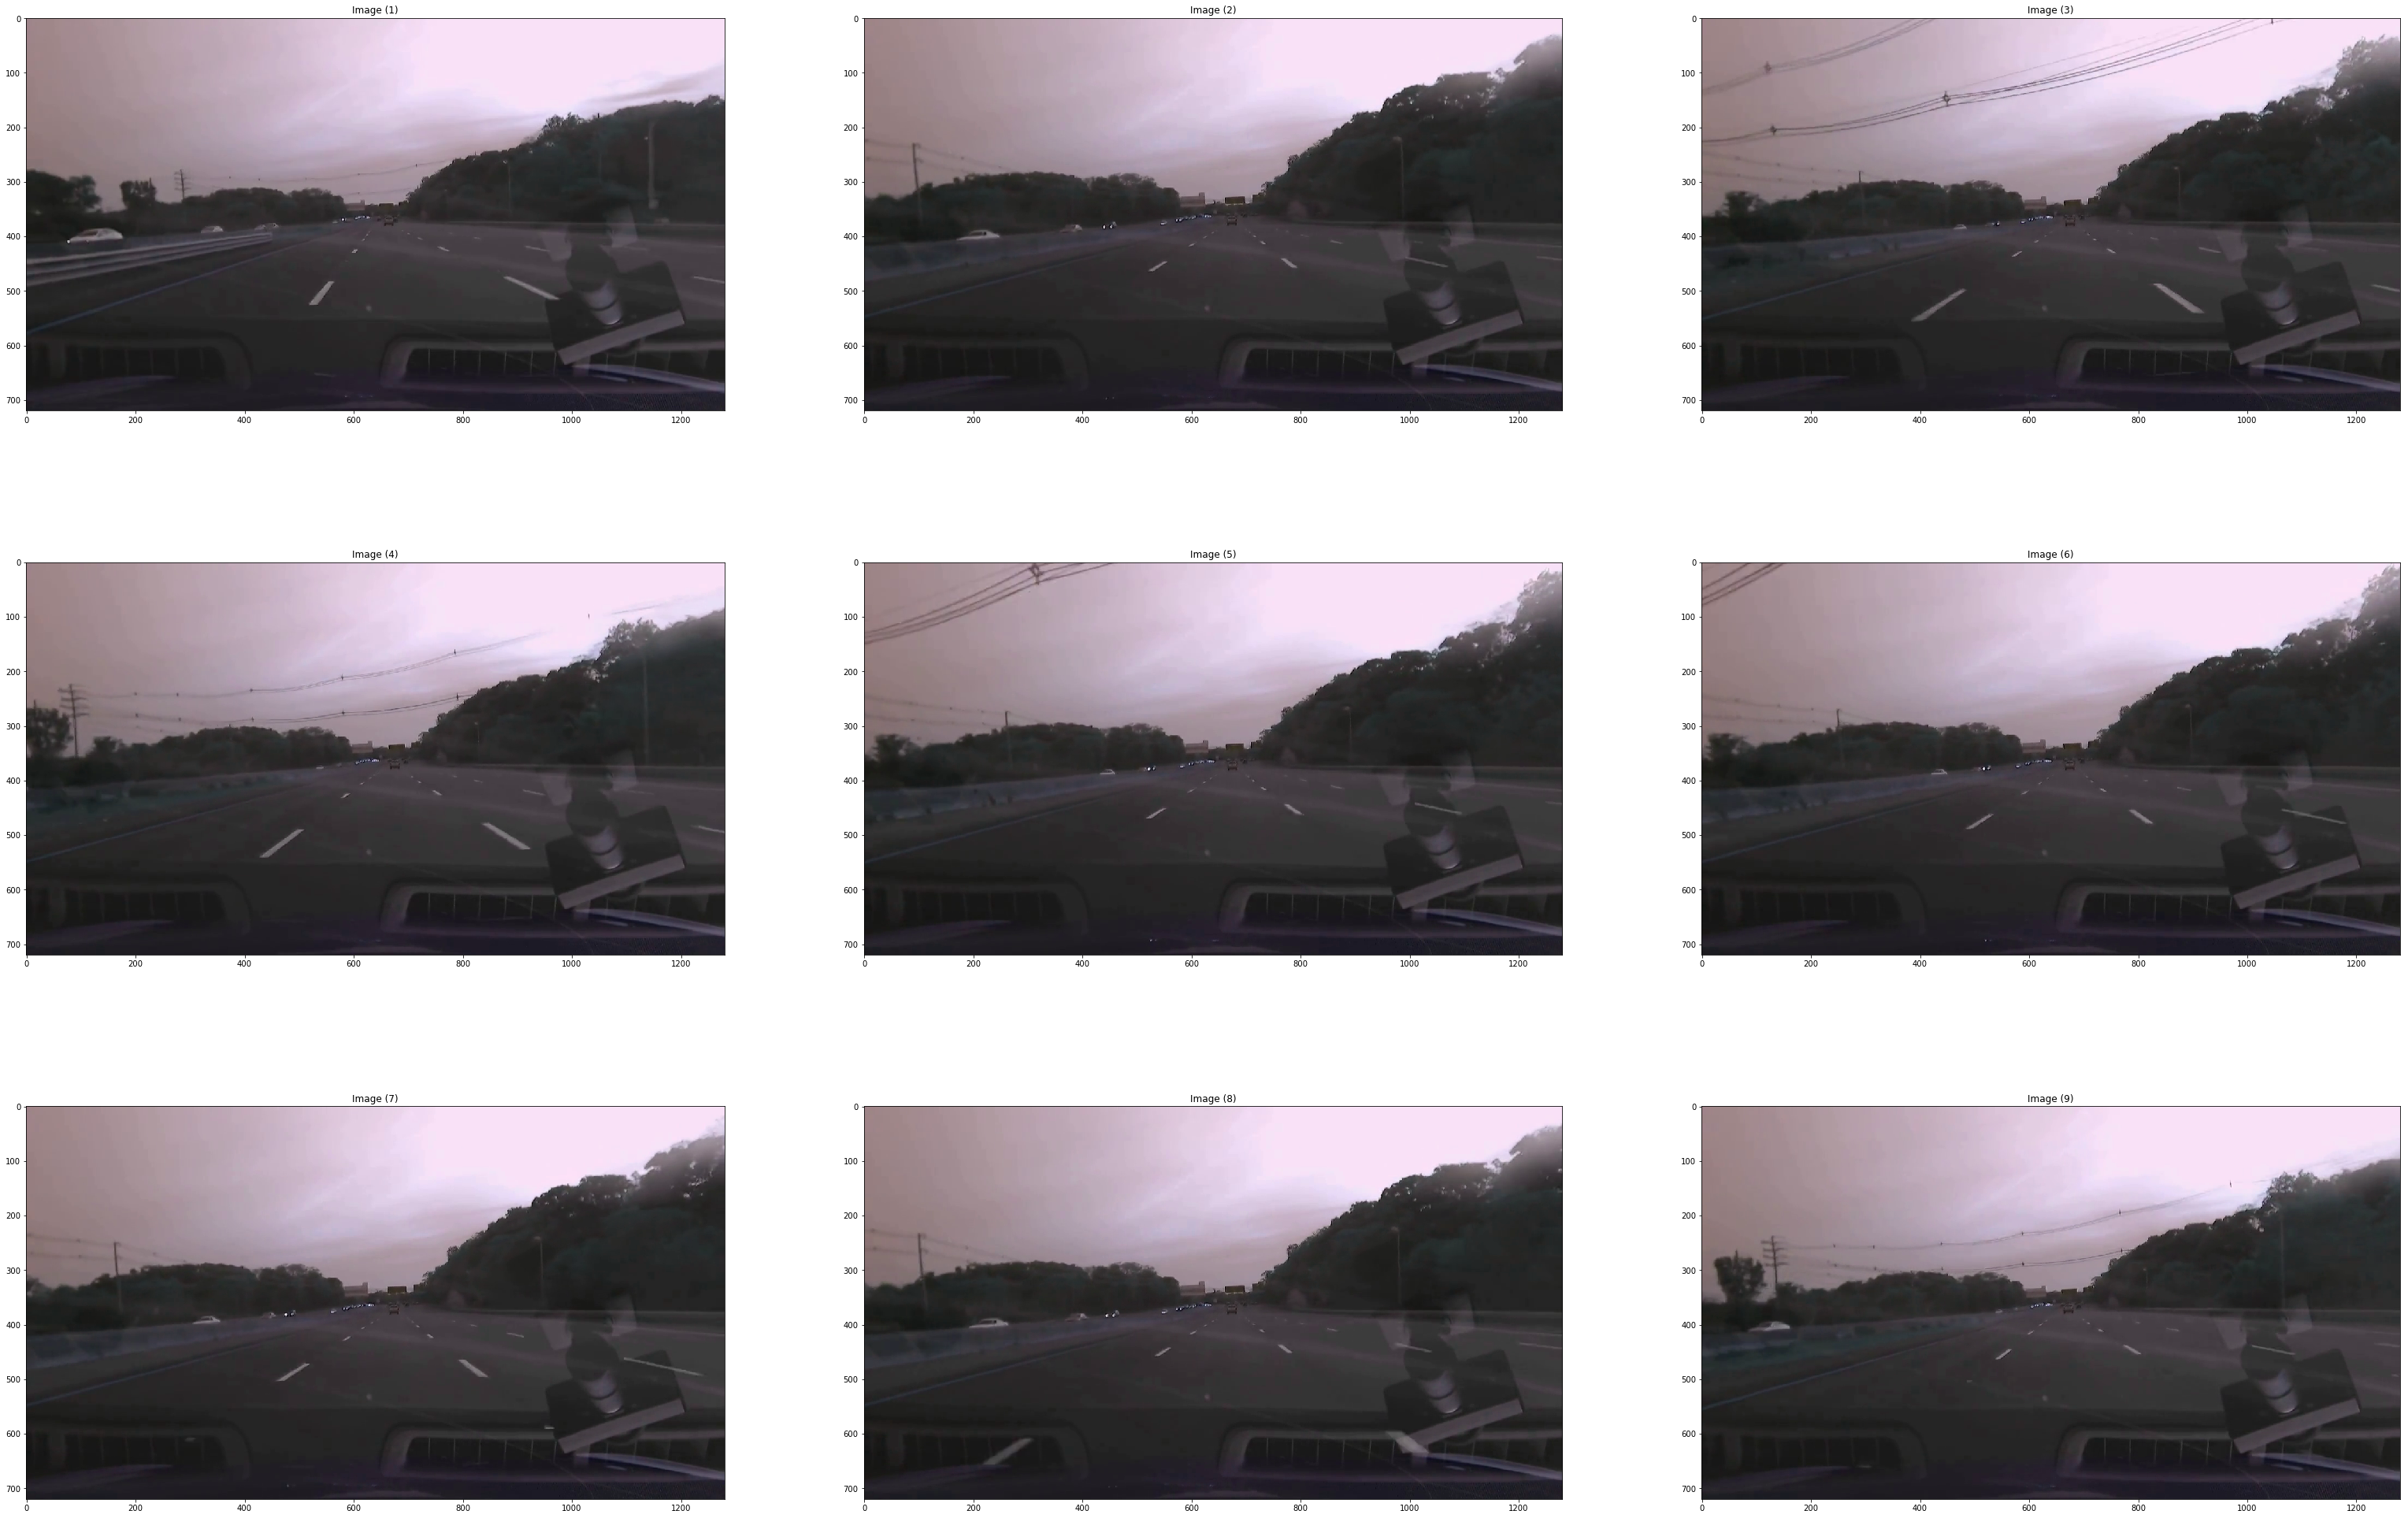

In [2]:
## Load front-roadway data
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
%matplotlib inline

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

import random
def get_random_images():
    imgs = []
    cap = cv2.VideoCapture("./epochs/epoch01_front.mkv")
    for i in range(100):
        ret, img = cap.read()
        if(ret):
            imgs.append(img)
    cap.release()
    random_imgs = []
    for i in range(9):
        index = random.randint(0, 99)
        random_imgs.append(imgs[index])
    return random_imgs

show_images(get_random_images(),cols=3)

　　再来看看项目输出，其中，ts_micro表示时间戳，frame_index表示帧编号，wheel表示方向盘转向角度（以水平方向为基准，+为顺时针，-为逆时针）
输出

In [3]:
import pandas as pd
wheel_sig = pd.read_csv('./epochs/epoch01_steering.csv')
wheel_sig.head()

,ts_micro,frame,wheel
0,1464650070285914,0,-1.0
1,1464650070319247,1,-1.0
2,1464650070352581,2,-1.0
3,1464650070385914,3,-1.0
4,1464650070419247,4,-1.0


### 探索性可视化

　　将第一段视频的输出汇总成柱状图和折线图如下。从这两个图可以看到，分布在0附近的信号较多，有可能会对大转变不够敏感，但总体而言数据的分布差距不是很大，模型可以学到有价值的转身策略。

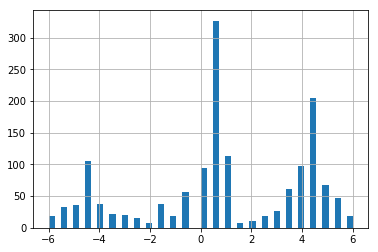

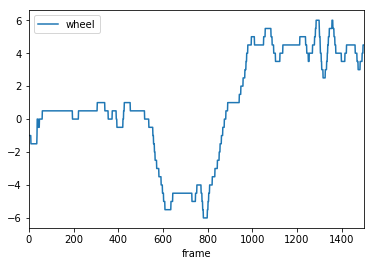

In [19]:
wheel_sig.wheel.hist(bins=50)
wheel_sig.plot(x='frame',y='wheel')

### 算法和技术

　　该项目是一个监督回归问题。训练数据集中对应每一帧图像都给定了相应的方向盘转向角度。此处使用端到端(end-to-end)模型，端到端模型指的是输入是原始数据，输出是最后的结果。在本问题中，输入X是前置摄像头获取的单帧图片，而最后的结果Y为转向角度，我们的目标就是通过训练学习到一个端到端模型f，利用该模型则可以预测转向角度Y，其关系为Y=f(X)。

　　由于具有图片状态空间巨大、图像含义在不同位置的平移不变性(translation invariance)等特点，传统的监督学习算法并不适用，目前最适合于图片检测的算法是卷积神经网络(CNN)。卷积神经网络不同层之间的神经元并不是全连接，而是采用局部连接的方式，这使得网络上的参数大大减少，并且共享权重，具有很好的物体平移不变性。

　　在训练中，涉及到的参数如下：

- 预处理:图片尺寸(size)，感兴趣区域（region of interest,ROI）
- 超参数:训练次数(epoch),批处理大小(batch size),优化器类型(optimizer type),学习速率(learning rate)
- 神经网络架构:网络层数(layers),网络层类型(layer types)，网络层初始化参数及偏置项(weights and bias)

### 基准模型

　　英伟达（NVIDIA）一直以来发力进行深度学习和无人驾驶的研究，今年年初NVIDIA就发表了一篇论文介绍如何利用CNNs实现端到端的无人驾驶[3]。此处采用该模型来作为基准模型。

　　如下图所示，该模型第一层为归一化层，接下来的紧跟着5个卷积层，在卷积层后增加3个全连接层。
　　
![](images/15028711627212.jpg)

## III. 方法

### 数据预处理

数据预处理中，本项目做了以下处理。

先将视频中的所有图片提取出来，并且提取输出结果，使图片与输出一一对应。

由于图片尺寸比较大（720，1200，3），并且无用区域较多，此处会对所有图片进行裁剪，只留下感兴趣区域。

In [24]:
import datasets
(X_train, y_train), (X_test, y_test) = datasets.load_data()
n_train, n_test = X_train.shape[0], X_test.shape[0]

### 执行过程
在这一部分， 你需要描述你所建立的模型在给定数据上执行过程。模型的执行过程，以及过程中遇到的困难的描述应该清晰明了地记录和描述。需要考虑的问题：
- _你所用到的算法和技术执行的方式是否清晰记录了？_
- _在运用上面所提及的技术及指标的执行过程中是否遇到了困难，是否需要作出改动来得到想要的结果？_
- _是否有需要记录解释的代码片段(例如复杂的函数）？_

1.跑英伟达的模型，得到train_loss, val_loss,test_loss
2.简单介绍自己的模型并跑自己的模型，得到train_loss, val_loss,test_loss

该项目实现了两种模型来测试效果，分别是分别是英伟达提出的端到端卷积神经网络模型和基于迁移学习的VGG16模型。以下是实现及结果

#### 英伟达端到端卷积神经网络模型

英伟达模型的情况在基准模型章节已经有介绍，此处就不再描述。代码实现如下

In [25]:
from keras.layers import *
from keras.models import Model
from keras import optimizers
import keras
import params

inputs = Input(shape=(params.FLAGS.img_h, params.FLAGS.img_w, params.FLAGS.img_c))
x=Lambda(lambda x:x/255.0-0.5)(inputs)
x=Conv2D(24, (5, 5), activation="relu", strides=(2, 2), padding="valid")(x)
x=Conv2D(36, (5, 5), activation="relu", strides=(2, 2), padding="valid")(x)
x=Conv2D(48, (5, 5), activation="relu", strides=(2, 2), padding="valid")(x)
x=Conv2D(64, (3, 3), activation="relu", strides=(1, 1), padding="valid")(x)
x=Conv2D(64, (3, 3), activation="relu", strides=(1, 1), padding="valid")(x)
x=Flatten()(x)
x=Dense(1164, activation='relu')(x)
x=Dense(100, activation='relu')(x)
x=Dense(50, activation='relu')(x)
x=Dense(10, activation='relu')(x)
outputs=Dense(1, activation='tanh')(x)
model = Model(inputs=inputs,outputs=outputs)
model.compile(optimizer=optimizers.Adadelta(),
              loss='mse',
              metrics=['mse'])
model.fit(x=X_train,y=y_train,epochs=10,validation_split=0.2)

Train on 19440 samples, validate on 4860 samples
Epoch 1/10
19440/19440 [==============================] - 83s - loss: 19.9846 - mean_squared_error: 19.9846 - val_loss: 13.1744 - val_mean_squared_error: 13.1744
Epoch 2/10
19440/19440 [==============================] - 81s - loss: 18.1755 - mean_squared_error: 18.1755 - val_loss: 13.0669 - val_mean_squared_error: 13.0669
Epoch 3/10
19440/19440 [==============================] - 76s - loss: 17.8431 - mean_squared_error: 17.8431 - val_loss: 12.6891 - val_mean_squared_error: 12.6891
Epoch 4/10
19440/19440 [==============================] - 82s - loss: 17.5887 - mean_squared_error: 17.5887 - val_loss: 12.5965 - val_mean_squared_error: 12.5965
Epoch 5/10
19440/19440 [==============================] - 83s - loss: 17.4875 - mean_squared_error: 17.4875 - val_loss: 12.9834 - val_mean_squared_error: 12.9834
Epoch 6/10
19440/19440 [==============================] - 81s - loss: 17.4357 - mean_squared_error: 17.4357 - val_loss: 13.4343 - val_mean_sq

#### VGG16模型

介绍VGG16

VGG16是Very Deep Convolutional Networks for Large-Scale Image Recognition这篇论文中提出的一种用于大规模图像识别的深度卷积神经网络，作者是剑桥大学和Google DeepMind的研究人员。它的模型设计比较复杂，大体思想是用较小的卷积核（3x3）和较深的卷积网络（16–19层）来实现对图像通用特征的识别和提取，在实践中训练VGG16的数据集主要来自于ImageNet，论文请见[引用10]。

VGG16可以在ImageNet这种涵盖多种类物体图像的大规模数据集上进行训练，对ImageNet中包括的景物有较强的识别能力，我们可以借鉴迁移学习的思想，利用VGG16优化我们的模型。简单概括，迁移学习就是把一个预先训练好的模型，用于另一个类似的任务上，以达到节省训练时间、提高模型效果的目的。在我们设计的第二个模型中，我们设计了一种以VGG16为特征提取网络的模型，同时在顶层添加全连接层（full connected）进行预测，可以减少我们特征提取的成本，提高我们训练的效率。

对于图片分类而言，为了增加分类效果，一种有效的措施就是增加 卷积神经网络的层数。但层数越深，网络 parameters 越多，权重空间变得巨大 (exponential)，由于 curse of dimensionality [8] 的影响，训练深度网络所需要的数据 量也是巨大的。另外，网络结构越深，越容易出现 overfitting。简单来说层数越深也就 越不容易训练。我们知道对于卷积神经网络，低层的权重记忆了很多通用的特性，比 如颜色、边缘等信息，而高层的权重则记忆了具体特性，例如物体形状、大小等信息。 所以我们可以利用一个已经经过大数据集充分训练的模型，保留该模型的底层 weights，来微调该模型的高层 weights。在微调高层 weights 后，我们也可以微调一些 低层 weights 来让模型收敛到更佳的位置。
VGG 模型是在 LSVRC-14 提出的一系列模型，其中 16 层模型和 19 层模型在 ImageNet 上表现最好，这两个模型在后来就被称作 VGG16 和 VGG19。VGG 模型的 结构很简单，整个模型由几组相同 filter 的卷积层叠加而成，filter 大小均是 3x3，每一 组卷积层后面叠加一个相同的 MaxPooling 层。[3]
基于 VGG16 模型简洁和直观性，在考虑使用卷积神经网络解决图像问题时，通常可 以先使用 VGG16 来对数据集进行验证，如果 VGG 模型能得到不错的效果，可以再考 虑对模型进行优化或使用层数更多的模型。



此处VGG16实现如下，

In [29]:
inputs = Input(shape=(params.FLAGS.img_h, params.FLAGS.img_w, params.FLAGS.img_c))
x=Lambda(lambda x:x/255.0-0.5)(inputs)
x=Conv2D(64, (3, 3), activation="relu", strides=(1, 1), padding="same")(x)
x=Conv2D(64, (3, 3), activation="relu", strides=(1, 1), padding="same")(x)
x=MaxPooling2D(pool_size=(2,2),strides=(2, 2))(x)

x=Conv2D(128, (3, 3), activation="relu", strides=(1, 1), padding="same")(x)
x=Conv2D(128, (3, 3), activation="relu", strides=(1, 1), padding="same")(x)
x=MaxPooling2D(pool_size=(2,2),strides=(2, 2))(x)

x=Conv2D(256, (3, 3), activation="relu", strides=(1, 1), padding="same")(x)
x=Conv2D(256, (3, 3), activation="relu", strides=(1, 1), padding="same")(x)
x=Conv2D(256, (3, 3), activation="relu", strides=(1, 1), padding="same")(x)
x=MaxPooling2D(pool_size=(2,2),strides=(2, 2))(x)

x=Conv2D(512, (3, 3), activation="relu", strides=(1, 1), padding="same")(x)
x=Conv2D(512, (3, 3), activation="relu", strides=(1, 1), padding="same")(x)
x=Conv2D(512, (3, 3), activation="relu", strides=(1, 1), padding="same")(x)
x=MaxPooling2D(pool_size=(2,2),strides=(2, 2))(x)

x=Conv2D(512, (3, 3), activation="relu", strides=(1, 1), padding="same")(x)
x=Conv2D(512, (3, 3), activation="relu", strides=(1, 1), padding="same")(x)
x=Conv2D(512, (3, 3), activation="relu", strides=(1, 1), padding="same")(x)
x=MaxPooling2D(pool_size=(2,2),strides=(2, 2))(x)

x=Flatten()(x)
x=Dense(512, activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(256, activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(64, activation='relu')(x)
x=Dropout(0.5)(x)
outputs=Dense(1, activation='tanh')(x)
model = Model(inputs=inputs,outputs=outputs)
model.load_weights('./models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
model.compile(optimizer=optimizers.Adadelta(),
              loss='mse',
              metrics=['mse'])
model.fit(x=X_train,y=y_train,epochs=10,validation_split=0.2)

ValueError: You are trying to load a weight file containing 13 layers into a model with 17 layers.

### 完善
在这一部分，你需要描述你对原有的算法和技术完善的过程。例如调整模型的参数以达到更好的结果的过程应该有所记录。你需要记录最初和最终的模型，以及过程中有代表性意义的结果。你需要考虑的问题：
- _初始结果是否清晰记录了？_
- _完善的过程是否清晰记录了，其中使用了什么技术？_
- _完善过程中的结果以及最终结果是否清晰记录了？_

1.调整上面的模型，得到train_loss, val_loss,test_loss，直到val_loss小于1

## IV. 结果
_（大概 2-3 页）_

### 模型的评价与验证
在这一部分，你需要对你得出的最终模型的各种技术质量进行详尽的评价。最终模型是怎么得出来的，为什么它会被选为最佳需要清晰地描述。你也需要对模型和结果可靠性作出验证分析，譬如对输入数据或环境的一些操控是否会对结果产生影响（敏感性分析sensitivity analysis）。一些需要考虑的问题：
- _最终的模型是否合理，跟期待的结果是否一致？最后的各种参数是否合理？_
- _模型是否对于这个问题是否足够稳健可靠？训练数据或输入的一些微小的改变是否会极大影响结果？（鲁棒性）_
- _这个模型得出的结果是否可信？_

1.回答上述三个问题

### 合理性分析
在这个部分，你需要利用一些统计分析，把你的最终模型得到的结果与你的前面设定的基准模型进行对比。你也分析你的最终模型和结果是否确确实实解决了你在这个项目里设定的问题。你需要考虑：
- _最终结果对比你的基准模型表现得更好还是有所逊色？_
- _你是否详尽地分析和讨论了最终结果？_
- _最终结果是不是确确实实解决了问题？_

1.使用各种图去比较上面三个模型的结果，并得出结论

## V. 项目结论
_（大概 1-2 页）_

### 结果可视化
在这一部分，你需要用可视化的方式展示项目中需要强调的重要技术特性。至于什么形式，你可以自由把握，但需要表达出一个关于这个项目重要的结论和特点，并对此作出讨论。一些需要考虑的：
- _你是否对一个与问题，数据集，输入数据，或结果相关的，重要的技术特性进行了可视化？_
- _可视化结果是否详尽的分析讨论了？_
- _绘图的坐标轴，标题，基准面是不是清晰定义了？_

生成的视频描述一下


### 对项目的思考
在这一部分，你需要从头到尾总结一下整个问题的解决方案，讨论其中你认为有趣或困难的地方。从整体来反思一下整个项目，确保自己对整个流程是明确掌握的。需要考虑：
- _你是否详尽总结了项目的整个流程？_
- _项目里有哪些比较有意思的地方？_
- _项目里有哪些比较困难的地方？_
- _最终模型和结果是否符合你对这个问题的期望？它可以在通用的场景下解决这些类型的问题吗？_
1.总结并回答上面4个问题


### 需要作出的改进
在这一部分，你需要讨论你可以怎么样去完善你执行流程中的某一方面。例如考虑一下你的操作的方法是否可以进一步推广，泛化，有没有需要作出变更的地方。你并不需要确实作出这些改进，不过你应能够讨论这些改进可能对结果的影响，并与现有结果进行比较。一些需要考虑的问题：
- _是否可以有算法和技术层面的进一步的完善？_
- _是否有一些你了解到，但是你还没能够实践的算法和技术？_
- _如果将你最终模型作为新的基准，你认为还能有更好的解决方案吗？_
1.回答三个问题